# Демонстрация Simple (Vanilla) RNN в PyTorch

In [1]:
import torch
from torch import nn

### 1. Однонаправленная однослойная Simple RNN
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html

Задаем параметры сети:

In [2]:
seq_len = 3             # Длина входной последовательности
batch_size = 2          # Размер батча
input_size = 2          # Размерность входа (количество признаков)
hidden_size = 3         # Размерность скрытого состояния
num_layers = 1          # Количество слоев
nonlinearity='tanh'     # Функция активации
bidirectional = False   # Двунаправленность сети
if bidirectional:       
    num_directions = 2
else:
    num_directions = 1

Обеспечиваем воспроизводимость результатов (https://pytorch.org/docs/stable/notes/randomness.html):

In [3]:
torch.manual_seed(0)

Создаем RNN-сеть:

In [4]:
rnn_1_layers = nn.RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    nonlinearity=nonlinearity,
    bias=True,
    batch_first=False,
    dropout=0,
    bidirectional=bidirectional
)
rnn_1_layers

RNN(2, 3)

Зададим функцию для вывода весов с названиями переменных:

In [5]:
def print_named_parameters(model):
    s = 0
    for parameter in model.named_parameters():
        print(f'\n{parameter[0]}: {list(parameter[1].data.size())} - {parameter[1].numel()} weights\n{parameter[1].data}')
        s += parameter[1].numel()
    print(f'\nTotal number of parameters = {s}')

Выводим все веса с названиями переменных:

In [6]:
print_named_parameters(rnn_1_layers)


weight_ih_l0: [3, 2] - 6 weights
tensor([[-0.0043,  0.3097],
        [-0.4752, -0.4249],
        [-0.2224,  0.1548]])

weight_hh_l0: [3, 3] - 9 weights
tensor([[-0.0114,  0.4578, -0.0512],
        [ 0.1528, -0.1745, -0.1135],
        [-0.5516, -0.3824, -0.2380]])

bias_ih_l0: [3] - 3 weights
tensor([0.0214, 0.2282, 0.3464])

bias_hh_l0: [3] - 3 weights
tensor([-0.3914, -0.2514,  0.2097])

Total number of parameters = 21


---
Задаем вход сети:
- последовательность из `seq_len` батчей,
- в каждом батче `batch_size` примеров,
- размерность каждого примера: `input_size`

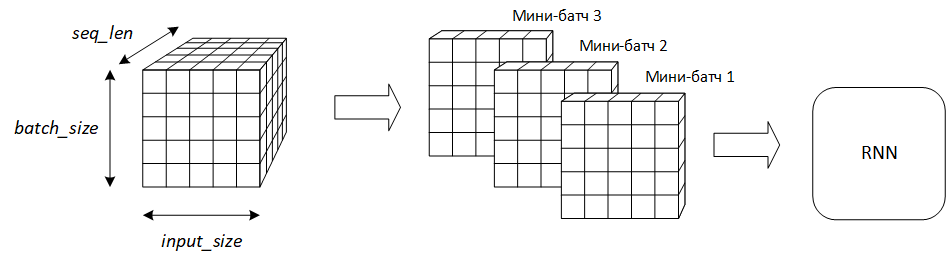

In [7]:
# shape of input: (seq_len, batch_size, input_size)

m = 1
input_data = torch.Tensor()
for i in range(seq_len):
    
    batch = torch.Tensor()
    
    for j in range(batch_size):
        sample = torch.Tensor()
    
        for k in range(input_size):
            new_element = torch.tensor([m])
            sample = torch.cat((sample, new_element), dim=0)
            m += 1
        
        sample = sample.reshape(1, input_size)
        
        batch = torch.cat((batch, sample), dim=0)
    
    batch = batch.reshape(1, batch_size, input_size)
    input_data = torch.cat((input_data, batch), dim=0)

print(f'input_data.shape = {input_data.shape}')
print(f'\ninput_data:\n{input_data}')

input_data.shape = torch.Size([3, 2, 2])

input_data:
tensor([[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 5.,  6.],
         [ 7.,  8.]],

        [[ 9., 10.],
         [11., 12.]]])


---
Подаем на сеть входные данные, выводим результат:

In [8]:
# shape of output: (seq_len, batch_size, num_directions * hidden_size)
output_rnn_1_layers, hn_rnn_1_layers = rnn_1_layers(input_data)

print(f'output.shape = {output_rnn_1_layers.shape}')
print(f'\noutput = {output_rnn_1_layers.data}')
print(f'\nhn.shape = {hn_rnn_1_layers.shape}')
print(f'\nhn = {hn_rnn_1_layers.data}')

output.shape = torch.Size([3, 2, 3])

output = tensor([[[ 0.2403, -0.8736,  0.5672],
         [ 0.6941, -0.9963,  0.4686]],

        [[ 0.7759, -0.9999,  0.4134],
         [ 0.9201, -1.0000,  0.1240]],

        [[ 0.9758, -1.0000, -0.0410],
         [ 0.9930, -1.0000, -0.1846]]])

hn.shape = torch.Size([1, 2, 3])

hn = tensor([[[ 0.9758, -1.0000, -0.0410],
         [ 0.9930, -1.0000, -0.1846]]])


---
Воспроизведём поведение RNN-сети при помощи самостоятельно заданной функции.  
Скрытое состояние и выход RNN-сети на шаге $t$ определяется по формуле:  

$$h_t=tanh(Ux_t+b_{ih}+Wh_{t-1}+b_{hh})$$

In [9]:
def rnn_function(x, h, U, W, b):
    outputs = torch.Tensor()
    
    # Проходим по последовательности входов
    for i, x_t in enumerate(x):
        print(f'---------- Мини-батч {i+1} из {len(x)} ----------')
        print(f'x_t (shape = {list(x_t.shape)}):\n{x_t.data}\n')
        
        print(f'U (shape = {list(U.shape)}):\n{U.data}\n')
        
        U_x = torch.matmul(U, x_t.T)
        
        print(f'U_x (shape = {list(U_x.shape)}):\n{U_x.data}\n')
        
        print(f'W (shape = {list(W.shape)}):\n{W.data}\n')
        
        print(f'h_t-1 (shape = {list(h.shape)}):\n{h.data}\n')      
        
        W_h = torch.matmul(W, h.T)
        
        print(f'W_h (shape = {list(W_h.shape)}):\n{W_h.data}\n')
        
        b = b.reshape(W_h.shape[0], 1)
        
        b_multiple = torch.Tensor()
        for j in range(W_h.shape[1]):
            b_multiple = torch.cat((b_multiple, b), dim=1)
        
        print(f'b (shape = {list(b_multiple.shape)}):\n{b_multiple.data}\n')
        
        sum = U_x + W_h + b_multiple
        
        print(f'U_x + W_h + b (shape = {list(sum.shape)}):\n{sum.data}\n')
        
        h = torch.tanh(sum)
        h = h.T
        
        print(f'h (shape = {list(h.shape)})\n{h.data}\n')
        print()
        
        outputs = torch.cat((outputs, h), dim=0)
        
    return outputs

Скрытое состояние = 0.  
Матрицы берем из созданной RNN-сети:

In [10]:
h0 = torch.zeros(batch_size, num_directions * hidden_size)
W0 = rnn_1_layers.weight_hh_l0
U0 = rnn_1_layers.weight_ih_l0
b0 = rnn_1_layers.bias_hh_l0 + rnn_1_layers.bias_ih_l0

output0 = rnn_function(input_data, h0, U0, W0, b0)
print(f'********** Результат **********\n\n{output0.data}')

---------- Мини-батч 1 из 3 ----------
x_t (shape = [2, 2]):
tensor([[1., 2.],
        [3., 4.]])

U (shape = [3, 2]):
tensor([[-0.0043,  0.3097],
        [-0.4752, -0.4249],
        [-0.2224,  0.1548]])

U_x (shape = [3, 2]):
tensor([[ 0.6151,  1.2259],
        [-1.3250, -3.1251],
        [ 0.0873, -0.0478]])

W (shape = [3, 3]):
tensor([[-0.0114,  0.4578, -0.0512],
        [ 0.1528, -0.1745, -0.1135],
        [-0.5516, -0.3824, -0.2380]])

h_t-1 (shape = [2, 3]):
tensor([[0., 0., 0.],
        [0., 0., 0.]])

W_h (shape = [3, 2]):
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

b (shape = [3, 2]):
tensor([[-0.3700, -0.3700],
        [-0.0232, -0.0232],
        [ 0.5561,  0.5561]])

U_x + W_h + b (shape = [3, 2]):
tensor([[ 0.2451,  0.8559],
        [-1.3481, -3.1483],
        [ 0.6434,  0.5083]])

h (shape = [2, 3])
tensor([[ 0.2403, -0.8736,  0.5672],
        [ 0.6941, -0.9963,  0.4686]])


---------- Мини-батч 2 из 3 ----------
x_t (shape = [2, 2]):
tensor([[5., 6.],
       

---
Сравним с результатом RNN, полученным выше:

In [11]:
output_rnn_1_layers.data

tensor([[[ 0.2403, -0.8736,  0.5672],
         [ 0.6941, -0.9963,  0.4686]],

        [[ 0.7759, -0.9999,  0.4134],
         [ 0.9201, -1.0000,  0.1240]],

        [[ 0.9758, -1.0000, -0.0410],
         [ 0.9930, -1.0000, -0.1846]]])

### 2. Однонаправленная двухслойная Simple RNN

Задаем количество слоёв:

In [12]:
num_layers = 2

Создаем сеть:

In [13]:
rnn_2_layers = nn.RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    nonlinearity=nonlinearity,
    bias=True,
    batch_first=False,
    dropout=0,
    bidirectional=bidirectional
)
rnn_2_layers

RNN(2, 3, num_layers=2)

Выводим все веса с названиями переменных:

In [14]:
print_named_parameters(rnn_2_layers)


weight_ih_l0: [3, 2] - 6 weights
tensor([[ 0.4794, -0.1188],
        [ 0.4320, -0.0931],
        [ 0.0611,  0.5228]])

weight_hh_l0: [3, 3] - 9 weights
tensor([[-0.5356, -0.3635, -0.1462],
        [-0.2251,  0.4988, -0.3742],
        [-0.2658, -0.4034, -0.5407]])

bias_ih_l0: [3] - 3 weights
tensor([-0.3370,  0.4963,  0.2576])

bias_hh_l0: [3] - 3 weights
tensor([ 0.2798,  0.0304, -0.2960])

weight_ih_l1: [3, 3] - 9 weights
tensor([[ 0.0977, -0.5391, -0.4172],
        [-0.2976,  0.3643,  0.3385],
        [-0.2561, -0.0208,  0.3693]])

weight_hh_l1: [3, 3] - 9 weights
tensor([[ 0.5740,  0.2291,  0.0780],
        [ 0.3871, -0.3399,  0.1076],
        [-0.4476, -0.4002, -0.2982]])

bias_ih_l1: [3] - 3 weights
tensor([ 0.2612,  0.2322, -0.3420])

bias_hh_l1: [3] - 3 weights
tensor([ 0.1744,  0.3169, -0.0729])

Total number of parameters = 45


---
Подаем на сеть входные данные, выводим результат:

In [15]:
# shape of output: (seq_len, batch_size, num_directions * hidden_size)
output_rnn_2_layers, hn_rnn_2_layers = rnn_2_layers(input_data)

print(f'output.shape = {output_rnn_2_layers.shape}')
print(f'\noutput = {output_rnn_2_layers.data}')
print(f'\nhn.shape = {hn_rnn_2_layers.shape}')
print(f'\nhn = {hn_rnn_2_layers.data}')

output.shape = torch.Size([3, 2, 3])

output = tensor([[[-0.2214,  0.7608, -0.1818],
         [-0.3668,  0.7583, -0.2513]],

        [[-0.3690,  0.5568, -0.4072],
         [-0.4489,  0.5022, -0.3477]],

        [[-0.4933,  0.5269, -0.2464],
         [-0.5320,  0.5186, -0.2136]]])

hn.shape = torch.Size([2, 2, 3])

hn = tensor([[[ 0.9721,  0.9978,  0.9998],
         [ 0.9926,  0.9994,  1.0000]],

        [[-0.4933,  0.5269, -0.2464],
         [-0.5320,  0.5186, -0.2136]]])


---
Воспроизводим поведение RNN-сети при помощи ранее определенной функции:

In [16]:
# Матрицы берем из созданной сети
W0 = rnn_2_layers.weight_hh_l0
U0 = rnn_2_layers.weight_ih_l0
b0 = rnn_2_layers.bias_hh_l0 + rnn_2_layers.bias_ih_l0

W1 = rnn_2_layers.weight_hh_l1
U1 = rnn_2_layers.weight_ih_l1
b1 = rnn_2_layers.bias_hh_l1 + rnn_2_layers.bias_ih_l1

# Первый слой
print(f'********** Первый слой **********\n')
output0 = rnn_function(input_data, h0, U0, W0, b0)
input1 = output0.reshape(seq_len, batch_size, hidden_size)

# Второй слой
print(f'\n********** Второй слой **********\n')
output1 = rnn_function(input1, h0, U1, W1, b1)

print(f'\n********** Результат первого слоя **********\n\n{output0.data}')

print(f'\n********** Результат второго слоя **********\n\n{output1.data}')

********** Первый слой **********

---------- Мини-батч 1 из 3 ----------
x_t (shape = [2, 2]):
tensor([[1., 2.],
        [3., 4.]])

U (shape = [3, 2]):
tensor([[ 0.4794, -0.1188],
        [ 0.4320, -0.0931],
        [ 0.0611,  0.5228]])

U_x (shape = [3, 2]):
tensor([[0.2418, 0.9630],
        [0.2459, 0.9239],
        [1.1066, 2.2744]])

W (shape = [3, 3]):
tensor([[-0.5356, -0.3635, -0.1462],
        [-0.2251,  0.4988, -0.3742],
        [-0.2658, -0.4034, -0.5407]])

h_t-1 (shape = [2, 3]):
tensor([[0., 0., 0.],
        [0., 0., 0.]])

W_h (shape = [3, 2]):
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

b (shape = [3, 2]):
tensor([[-0.0572, -0.0572],
        [ 0.5267,  0.5267],
        [-0.0384, -0.0384]])

U_x + W_h + b (shape = [3, 2]):
tensor([[0.1846, 0.9058],
        [0.7726, 1.4505],
        [1.0683, 2.2360]])

h (shape = [2, 3])
tensor([[0.1825, 0.6484, 0.7888],
        [0.7191, 0.8958, 0.9774]])


---------- Мини-батч 2 из 3 ----------
x_t (shape = [2, 2]):
tensor([

In [17]:
output_rnn_2_layers.data

tensor([[[-0.2214,  0.7608, -0.1818],
         [-0.3668,  0.7583, -0.2513]],

        [[-0.3690,  0.5568, -0.4072],
         [-0.4489,  0.5022, -0.3477]],

        [[-0.4933,  0.5269, -0.2464],
         [-0.5320,  0.5186, -0.2136]]])

In [18]:
hn_rnn_2_layers.data

tensor([[[ 0.9721,  0.9978,  0.9998],
         [ 0.9926,  0.9994,  1.0000]],

        [[-0.4933,  0.5269, -0.2464],
         [-0.5320,  0.5186, -0.2136]]])

---
Для понимания смысла выходных данных RNN-сети полезно изучить следующую схему ($c$ – это состояние ячейки LSTM):

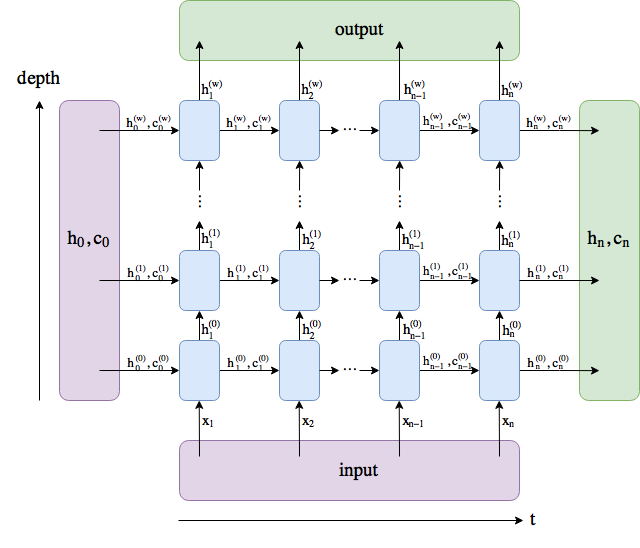

### 3. Двунаправленная однослойная Simple RNN

Задаем количество слоёв и двунаправленность:

In [19]:
num_layers = 1
bidirectional = True

Создаем сеть:

In [20]:
bi_rnn_1_layers = nn.RNN(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    nonlinearity=nonlinearity,
    bias=True,
    batch_first=False,
    dropout=0,
    bidirectional=bidirectional
)
bi_rnn_1_layers

RNN(2, 3, bidirectional=True)

Выводим все веса с названиями переменных:

In [21]:
print_named_parameters(bi_rnn_1_layers)


weight_ih_l0: [3, 2] - 6 weights
tensor([[ 0.0220,  0.1338],
        [ 0.3582,  0.5544],
        [-0.4449, -0.2116]])

weight_hh_l0: [3, 3] - 9 weights
tensor([[ 0.2269,  0.4784,  0.5024],
        [ 0.5094,  0.1149, -0.5021],
        [ 0.0531, -0.3612, -0.5381]])

bias_ih_l0: [3] - 3 weights
tensor([ 0.5130,  0.4390, -0.5759])

bias_hh_l0: [3] - 3 weights
tensor([ 0.1081, -0.0973, -0.0950])

weight_ih_l0_reverse: [3, 2] - 6 weights
tensor([[-0.2643,  0.2220],
        [-0.3420,  0.2117],
        [ 0.2920,  0.4133]])

weight_hh_l0_reverse: [3, 3] - 9 weights
tensor([[ 0.2159, -0.5714, -0.3745],
        [ 0.2883,  0.1208, -0.4504],
        [-0.3324,  0.5431,  0.3890]])

bias_ih_l0_reverse: [3] - 3 weights
tensor([-0.2517, -0.1453, -0.5500])

bias_hh_l0_reverse: [3] - 3 weights
tensor([-0.0104, -0.4348, -0.4453])

Total number of parameters = 42


---
Подаем на сеть входные данные, выводим результат:

In [22]:
# shape of output: (seq_len, batch_size, num_directions * hidden_size)
output_bi_rnn_1_layers, hn_bi_rnn_1_layers = bi_rnn_1_layers(input_data)

print(f'output.shape = {output_bi_rnn_1_layers.shape}')
print(f'\noutput = {output_bi_rnn_1_layers.data}')
print(f'\nhn.shape = {hn_bi_rnn_1_layers.shape}')
print(f'\nhn = {hn_bi_rnn_1_layers.data}')

output.shape = torch.Size([3, 2, 6])

output = tensor([[[ 0.7214,  0.9477, -0.9120,  0.0386, -0.8055,  0.0650],
         [ 0.8403,  0.9986, -0.9934, -0.0481, -0.8858,  0.9029]],

        [[ 0.9345,  1.0000, -0.9993, -0.1881, -0.9348,  0.9947],
         [ 0.9651,  1.0000, -0.9999, -0.2635, -0.9626,  0.9997]],

        [[ 0.9818,  1.0000, -1.0000, -0.3973, -0.9123,  1.0000],
         [ 0.9903,  1.0000, -1.0000, -0.4660, -0.9470,  1.0000]]])

hn.shape = torch.Size([2, 2, 3])

hn = tensor([[[ 0.9818,  1.0000, -1.0000],
         [ 0.9903,  1.0000, -1.0000]],

        [[ 0.0386, -0.8055,  0.0650],
         [-0.0481, -0.8858,  0.9029]]])


---
Для вызова собственной функции необходимо "перевернуть" входные данные для обратного прохода:

In [23]:
input_data

tensor([[[ 1.,  2.],
         [ 3.,  4.]],

        [[ 5.,  6.],
         [ 7.,  8.]],

        [[ 9., 10.],
         [11., 12.]]])

In [24]:
input_data.flip([0])

tensor([[[ 9., 10.],
         [11., 12.]],

        [[ 5.,  6.],
         [ 7.,  8.]],

        [[ 1.,  2.],
         [ 3.,  4.]]])

In [25]:
# Матрицы берем из созданной сети
W0 = bi_rnn_1_layers.weight_hh_l0
U0 = bi_rnn_1_layers.weight_ih_l0
b0 = bi_rnn_1_layers.bias_hh_l0 + bi_rnn_1_layers.bias_ih_l0

W0_reverse = bi_rnn_1_layers.weight_hh_l0_reverse
U0_reverse = bi_rnn_1_layers.weight_ih_l0_reverse
b0_reverse = bi_rnn_1_layers.bias_hh_l0_reverse + bi_rnn_1_layers.bias_ih_l0_reverse

# Прямой проход
print(f'********** Прямой проход **********\n')
output0 = rnn_function(input_data, h0, U0, W0, b0)

# Обратный проход
print(f'\n********** Обратный проход **********\n')
output0_reverse = rnn_function(input_data.flip([0]), h0, U0_reverse, W0_reverse, b0_reverse)

print(f'\n********** Результат прямого прохода **********\n\n{output0.data}')

print(f'\n********** Результат обратного прохода **********\n\n{output0_reverse.data}')

********** Прямой проход **********

---------- Мини-батч 1 из 3 ----------
x_t (shape = [2, 2]):
tensor([[1., 2.],
        [3., 4.]])

U (shape = [3, 2]):
tensor([[ 0.0220,  0.1338],
        [ 0.3582,  0.5544],
        [-0.4449, -0.2116]])

U_x (shape = [3, 2]):
tensor([[ 0.2896,  0.6012],
        [ 1.4669,  3.2920],
        [-0.8681, -2.1811]])

W (shape = [3, 3]):
tensor([[ 0.2269,  0.4784,  0.5024],
        [ 0.5094,  0.1149, -0.5021],
        [ 0.0531, -0.3612, -0.5381]])

h_t-1 (shape = [2, 3]):
tensor([[0., 0., 0.],
        [0., 0., 0.]])

W_h (shape = [3, 2]):
tensor([[0., 0.],
        [0., 0.],
        [0., 0.]])

b (shape = [3, 2]):
tensor([[ 0.6210,  0.6210],
        [ 0.3417,  0.3417],
        [-0.6709, -0.6709]])

U_x + W_h + b (shape = [3, 2]):
tensor([[ 0.9106,  1.2223],
        [ 1.8086,  3.6337],
        [-1.5390, -2.8520]])

h (shape = [2, 3])
tensor([[ 0.7214,  0.9477, -0.9120],
        [ 0.8403,  0.9986, -0.9934]])


---------- Мини-батч 2 из 3 ----------
x_t (shape

In [26]:
output_bi_rnn_1_layers.data

tensor([[[ 0.7214,  0.9477, -0.9120,  0.0386, -0.8055,  0.0650],
         [ 0.8403,  0.9986, -0.9934, -0.0481, -0.8858,  0.9029]],

        [[ 0.9345,  1.0000, -0.9993, -0.1881, -0.9348,  0.9947],
         [ 0.9651,  1.0000, -0.9999, -0.2635, -0.9626,  0.9997]],

        [[ 0.9818,  1.0000, -1.0000, -0.3973, -0.9123,  1.0000],
         [ 0.9903,  1.0000, -1.0000, -0.4660, -0.9470,  1.0000]]])

In [27]:
hn_bi_rnn_1_layers.data

tensor([[[ 0.9818,  1.0000, -1.0000],
         [ 0.9903,  1.0000, -1.0000]],

        [[ 0.0386, -0.8055,  0.0650],
         [-0.0481, -0.8858,  0.9029]]])

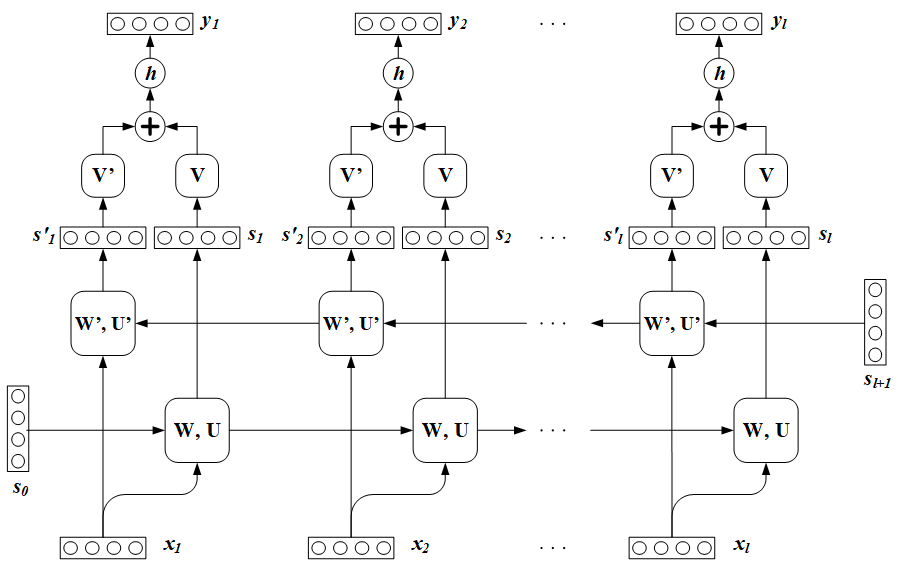